# *Everything You Ever Wanted to Know About Text Tokenization* (But Were Afraid to Ask)

* **Writers:** Thaís Martins, Thainara Assis, Gustavo Bernardo</font>

* **Reviewer:** João Gabriel Matos, Thaís Martins


# 1. Introduction


It’s been just over two years since large language models (LLMs) reached the general public and, for some, it still feels like magic how precise (or at least seemingly precise) their answers can be. But far from being any kind of magic, LLMs are simply models capable of processing and generating text after going through exhaustive training stages as Transformer layers, Backpropagation, Fine-Tuning and Reinforcement Learning.


However, for all this training to happen, a crucial yet often overlooked step must take place: the **Tokenization**. This is the first step of the process of converting text inputs into numbers so that machines can handle them. To achieve this, tokenizer models are trained to break text into smaller units called tokens, following a couple of specific rules and building their own dictionaries of these **tokens**, also called vocabularies. Once trained, the tokenizer can then map any new text into tokens and their IDs (indexes) by looking up matching pieces in its vocabulary . An example of the use of a pretrained tokenizer (in this case, the GPT tokenizer) is presented in Figure 1.[1,2]


### ***Figure 1: Illustrating the Tokenization Process***

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


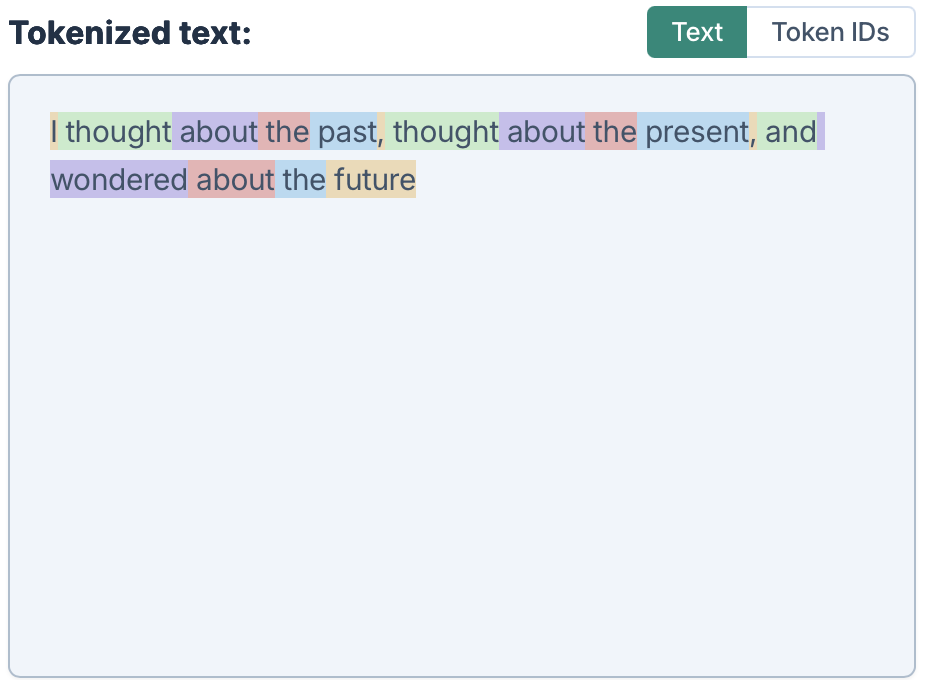

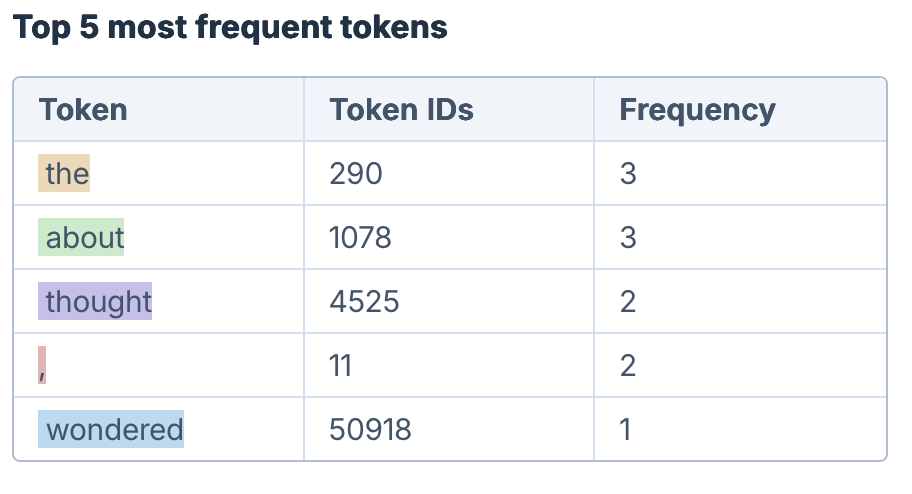

In [ ]:
# @title
from google.colab import drive
from IPython.display import Image, display

drive.mount('/content/drive')

display(Image(filename='/content/drive/MyDrive/Figuras do artigo - Tokenization/Figura 1/Captura de Tela 2025-10-22 às 08.33.26.png', width=450))
display(Image(filename='/content/drive/MyDrive/Figuras do artigo - Tokenization/Figura 1/Captura de Tela 2025-10-22 às 08.33.55.png', width=450))

***Caption.** Example of tokenization of an English sentence, showing both the tokenized text and the most frequent tokens with their IDs. Notice that the total number of tokens in the sentence is not the same as the number of unique dictionary entries, since repeated tokens share the same ID. The image was generated using gptforwork.com/tools/tokenizer. Try running your own experiments there to better understand how tokenization works!*

***Source.** GPT for Work's Online Tokenizer, available at https://gptforwork.com/tools/tokenizer.*


To make this idea more intuitive, we can think of Tokenization as the **chewing process in the digestive system**: just as chewing breaks food into smaller pieces so it can be swallowed and properly digested by stomach and intestines, tokenization breaks text into manageable units so that the subsequent training steps of LLMs – such as Transformers –  can learn from the information, or in other words,  extract nutrients from it.

There are a couple of different tokenization types and methods that we will go over in this article and to further understand their strengths and weaknesses, we propose four key metrics to evaluate them:


* **Coverage** → How well can the tokenizer represent any possible input? Can it handle rare words, numbers, emojis, and multilingual text without gaps?

* **Efficiency** → How compactly does the tokenizer encode text? Does it minimize the number of tokens per sentence while balancing vocabulary size and sequence length?

* **Consistency** → How uniform are the segmentation patterns? Does the same word always get segmented the same way? Are there redundant tokens?

* **Meaning Conservation**  →  Do the tokens generated have meaning unit? Does the tokenizer capture semantic relationships between similar words?



In short, achieving a consistent and efficient language model requires a well-designed tokenizer. This, in turn, demands training on a sufficiently large and diverse dataset to ensure a comprehensive vocabulary, so that no relevant text fragment is left unrepresented. At the same time, the tokenizer must segment the input into a reasonable number of tokens, avoiding both excessive fragmentation and redundancy.

## Setup


This section installs and configures all the dependencies required to run the notebook. The libraries listed below are essential for Natural Language Processing (NLP) tasks, data visualization, and text tokenization.

In [ ]:
# If this is your first time running the notebook,
# you can uncomment and run the commands below to install the required package

# !pip -q install transformers==4.* sentencepiece spacy tiktoken matplotlib pandas
# !pip install numpy pandas matplotlib
# !python -m spacy download en_core_web_sm

### Utilities

In [ ]:
%%capture
from typing import List
import string
import io, re, unicodedata
import numpy as np
import pandas as pd
import token
import matplotlib.pyplot as plt
from matplotlib import colors
import tokenize, textwrap as _tw
from typing import Callable, Dict, List, Iterable
from textwrap import dedent


# Function to avoid wrong lenghts in the function below
def safe_len(fn, text):
    try:
        toks = fn(text)
        return len(toks)
    except Exception:
        return None

#Compute the number of tokens produced by multiple tokenizers for each sentence.
def compute_token_counts(
    tokenizers: Dict[str, Callable[[str], List[str]]],
    sentences: Dict[str, str]
) -> Dict[str, List[int]]:
    counts = {name: [] for name in tokenizers}
    for _, sent in sentences.items():
        for name, fn in tokenizers.items():
            n = safe_len(fn, sent)
            counts[name].append(n if n is not None else np.nan)
    return counts

#Plot a grouped bar chart comparing token counts across tokenizers and sentences.
def plot_token_counts(
    counts: Dict[str, List[int]],
    labels: Iterable[str],
    title: str = "Comparing Tokenization Levels"
):
    labels = list(labels)
    x = np.arange(len(labels))
    series = list(counts.items())
    width = 0.8 / max(1, len(series))

    plt.figure(figsize=(4, 3), dpi=150)
    for i, (name, values) in enumerate(series):
        plt.bar(x + i * width, values, width, label=name)

    plt.title(title)
    plt.ylabel("Number of Tokens")
    plt.xlabel("Sentence Size")
    plt.xticks(x + (len(series) - 1) * width / 2, labels)
    plt.grid(True, linestyle="--", alpha=0.6, axis="y")
    plt.legend(fontsize=7)
    plt.tight_layout()
    plt.show()


# Function to show the tokens of a text, for a specific tokenizer model
def subword_tokenizer(texts, tokenizer):
  for text in texts:
    # Return string tokens (subwords) before mapping to IDs
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Display outputs to inspect token strings, token IDs, and decoder round-trips.
    print(f"Text: {text}")
    print("Tokens and their vocabulary indices:")

    # Create a pandas DataFrame for table formatting
    df = pd.DataFrame({'Token': tokens, 'Token ID': token_ids})
    display(df)
    print("\n")

### Load common tokenizers (first run may download models)


In [ ]:
%%capture
from transformers import AutoTokenizer

tok_bpe = AutoTokenizer.from_pretrained("gpt2")                 # BPE
tok_wp  = AutoTokenizer.from_pretrained("bert-base-uncased")    # WordPiece
tok_uni = AutoTokenizer.from_pretrained("google/mt5-small")     # Unigram (SentencePiece)

import spacy
nlp = spacy.load("en_core_web_sm")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


# 2. Word-Level Tokenization: the most intuitive alternative

It is understandable that the tokenization concept almost automatically evokes the idea of breaking the text into **words**, after all, that is the way we are already used to (at least speakers of English and Romance Languages).

The most intuitive and simple idea is to split sentences at every whitespace, a process known as **Whitespace-Based Tokenization (WBT)**. This is a rule-based tokenization technique, meaning it follows a fixed rule without any learnable parameters to optimize how text is segmented. As a result, the training phase of these tokenizers focuses only on building a vocabulary of known words and assigning them unique IDs. This is typically done by setting a maximum vocabulary size *k* and selecting the *k* most frequent words from the training corpus [3].

Although being very straightforward, it has several notable limitations [1], beginning with its **language dependent coverage**. As long as words are separated by whitespaces, as in English, Portuguese or French, they can be tokenized by this method. However whitespaces are not the paradigm in all writing systems. Some languages such as Japanese, Chinese, Hebrew, Thai or Burmese do not have explicit word boundary markers as whitespaces, making WBT incapable of tokenizing its texts [4]. In section 6, tokenization of other languages is discussed.

Another issue with this approach is related to **consistency**. Since token boundaries are defined solely by whitespaces, words followed by punctuation are treated as completely new tokens (as shown in Example 1 of our Colab Notebook, resulting in multiple entries of the same word, one for each punctuation variation, being added to the vocabulary [2].

Furthermore, this method fails to **conserve meaning relationships** between compound words and their components. For example, it fails to connect “sunflower” with “sun”, or “grandfather” with “father”. These relationships must be learned in later training stages, which is more expensive. In addition, WBT cannot reuse tokens from the component words and instead creates entirely new tokens for each compound word.

These factors inflate the vocabulary size required to represent what is essentially the same set of words. And because the vocabulary size is predetermined, it actually means that more words are likely to fall outside of it – these are known as **Out-Of-Vocabulary words (OOVs)** – as a result of the presence of these duplicates. It either reduces the **efficiency** of the tokenizer, due to the larger dictionary, or limits its coverage by increasing the number of OOVs [2].

An alternative to the WBT is the **Punctuation-Based Tokenization (PBT)**. Beyond whitespaces, this model also uses the punctuation of sentences to separate words into tokens. In this way, each punctuation mark will be stored in a separate token, preventing words followed by punctuation from being treated as new tokens, as occurred in whitespace-based tokenization [1].

Although it might solve the problem of punctuation-copies, this tokenization model still retains most WBT issues and also presents a new flaw [2]: there are situations where punctuation is inside words – as in the case of e-mails, phone numbers, URLs or decimal points – and we don't want these units to be split apart as the PBT will do, because it loses its semantic value, as we can see in Example 1.

In short, neither of these two raw tokenization methods performs well enough to serve as a final tokenizer in large-scale language models today [5]. Nevertheless, several modern tokenization pipelines still rely on an initial segmentation of text into words before further subword processing.

In such cases, it is common to employ tokenizers such as **SpaCy** [6], that uses carefully crafted rules and lexical exceptions rather than simple whitespace or punctuation splitting, providing a more robust pre-processing stage for downstream subword tokenization methods.

It is interesting to add that while it is common to normalize text by converting all words to lowercase, simplifying vocabulary by treating “Cat” and “cat” as the same token, SpaCy takes a different approach: it preserves the original casing of tokens, despite its increased memory usage and duplicate entries. This choice enhances linguistic accuracy in downstream tasks such as Named Entity Recognition (NER), where capitalization can carry important semantic meaning (e.g., Apple vs. apple)[6].

By doing so, SpaCy retains contextual information that would otherwise be lost through normalization, while it still allows normalization for later processing stages that may require case-insensitive input [6].


## Example 1 — Comparison between Whitespace-Based, Punctuation-Based Tokenization and SpaCy Outputs


> **Caption.** This code compares three tokenization strategies: Whitespace-Based Tokenization (WBT), Punctuation-Based Tokenization (PBT), and SpaCy’s rule-based tokenizer.
>- **WBT** simply splits text at whitespaces, leading to redundant tokens such as “programming.” and “programming”.
>- **PBT** separates punctuation into independent tokens, solving the duplication issue but incorrectly fragmenting elements like email addresses or decimal numbers.
>- **SpaCy** applies a linguistic, rule-based approach that accounts for punctuation, contractions, and special cases, preserving meaningful units like "did" + "n't", "tokenization.guy@mail.com" and "$1.234,56".

>The examples highlight the trade-offs between simplicity and linguistic precision across these tokenization methods.

In [ ]:
# Function for WBT tokenization
def manual_WBT(text):
    return text.split()

# Function for PBT tokenization
def manual_PBT(text):
    tokens = []
    current_token = ""
    for char in text:
        if char.isspace() or char in string.punctuation:
            if current_token:
                tokens.append(current_token)
                current_token = ""
            if char in string.punctuation:
                tokens.append(char)
        else:
            current_token += char
    if current_token:
        tokens.append(current_token)
    return tokens

In [ ]:
CASES = [
    "I love programming. Programming challenges are fun!",
    "She said she'll call when she gets home.",
    "tokenization.guy@mail.com",
    "Didn't it cost $1.234,56, did it?"
]

# Display outputs to inspect token strings
for s in CASES:
    print("Text Input:", s)
    print("WBT Output:  ", manual_WBT(s))
    print("PBT Output:  ", manual_PBT(s))
    print("SpaCy Output:",[token.text for token in nlp(s)])

    print("-" * 100)

Text Input: I love programming. Programming challenges are fun!
WBT Output:   ['I', 'love', 'programming.', 'Programming', 'challenges', 'are', 'fun!']
PBT Output:   ['I', 'love', 'programming', '.', 'Programming', 'challenges', 'are', 'fun', '!']
SpaCy Output: ['I', 'love', 'programming', '.', 'Programming', 'challenges', 'are', 'fun', '!']
----------------------------------------------------------------------------------------------------
Text Input: She said she'll call when she gets home.
WBT Output:   ['She', 'said', "she'll", 'call', 'when', 'she', 'gets', 'home.']
PBT Output:   ['She', 'said', 'she', "'", 'll', 'call', 'when', 'she', 'gets', 'home', '.']
SpaCy Output: ['She', 'said', 'she', "'ll", 'call', 'when', 'she', 'gets', 'home', '.']
----------------------------------------------------------------------------------------------------
Text Input: tokenization.guy@mail.com
WBT Output:   ['tokenization.guy@mail.com']
PBT Output:   ['tokenization', '.', 'guy', '@', 'mail', '.'

# 3. Character-Level Tokenization: Breaking it all the way down


The underlying logic of this type of tokenizer is straightforward: while a language may contain thousands of words, it is composed of a limited set of characters.

For instance, although there are approximately 170,000 distinct words in English, according to the Oxford English Dictionary [7], any text in this language can be represented with just a little over one hundred characters (not only the 26 letters, but also digits, whitespace, punctuation, and common symbols). [8]

To process texts in languages that use accent marks, different alphabets, emojis, or mathematical symbols, more than a hundred characters are needed. That is why Character-Level Tokenization relies on Unicode. Unicode is a standardized system that assigns a unique code point to every character across the world’s writing systems, as well as symbols, punctuation marks, and emojis [9].

This tokenization maps each code point to a single token, meaning that the total number of tokens in the sequence corresponds exactly to the number of characters in the input, as illustrated in Example 2.


## Example 2 — Character-Level: One Token per Unicode Code Point

> **Caption.** Each character (Unicode code point) becomes a token, guaranteeing coverage but producing longer sequences.

In [ ]:
samples = ["house", "language", "internationalization"]

for sample in samples:
    chars = list(sample)
    print(f"Word: {sample}")
    print("Characters:", chars, "| length:", len(chars))
    print("-" * 130)

Word: house
Characters: ['h', 'o', 'u', 's', 'e'] | length: 5
----------------------------------------------------------------------------------------------------------------------------------
Word: language
Characters: ['l', 'a', 'n', 'g', 'u', 'a', 'g', 'e'] | length: 8
----------------------------------------------------------------------------------------------------------------------------------
Word: internationalization
Characters: ['i', 'n', 't', 'e', 'r', 'n', 'a', 't', 'i', 'o', 'n', 'a', 'l', 'i', 'z', 'a', 't', 'i', 'o', 'n'] | length: 20
----------------------------------------------------------------------------------------------------------------------------------


The trade-off of this approach is that, while it keeps the dictionary relatively small compared to other tokenization methods – which can exceed 800,000 tokens – it generates much longer token sequences, as illustrated in Example 3. This leads to an efficiency issue, since it forces the model to use significantly more layers and parameters to capture dependencies across characters. As a result, the LLMs training becomes slower, more memory-intensive, and computationally expensive. [10]


## Example 3 — Sequence Length Growth at Character Level

> **Caption.** This example compares character counts for short, medium, and long samples. In short sentences, using character-level tokenization might not seem so disadvantageous, but as sentence length increases, its token sequences become extremely bigger than the sequences of word-level and subword-level tokenization – which is going to be discussed next.


In [ ]:
# Models used as examples
tokenizers = {
    "Word-Level (SpaCy)": lambda s: [token.text for token in nlp(s)],
    "Subword-Level (WordPiece - BERT)": lambda s: tok_wp.tokenize(s),
    "Character-Level": lambda s: list(s)
}

# Sentences used as examples
sentences = {
  "Small": "Artificial intelligence is transforming the way we use language.",
  "Medium": "Natural Language Processing, also known as NLP, is an interdisciplinary field that combines techniques from linguistics, statistics, and machine learning to enable computers to understand, interpret, and generate text in a way that increasingly resembles human language.",
  "Large": "Over the past decades, advances in language models have revolutionized the field of artificial intelligence. Models based on deep architectures, such as BERT, RoBERTa, and T5, have enabled remarkable achievements in tasks such as machine translation, sentiment analysis, question answering, text summarization, and even creative language generation. These models have become fundamental tools for research, business, and education, paving the way for innovative applications in virtually every area that depends on human communication. However, ethical and social challenges also arise, such as bias in models, the privacy of data used in training, and accountability for the use of these technologies, which must be carefully considered in the future of NLP."
}

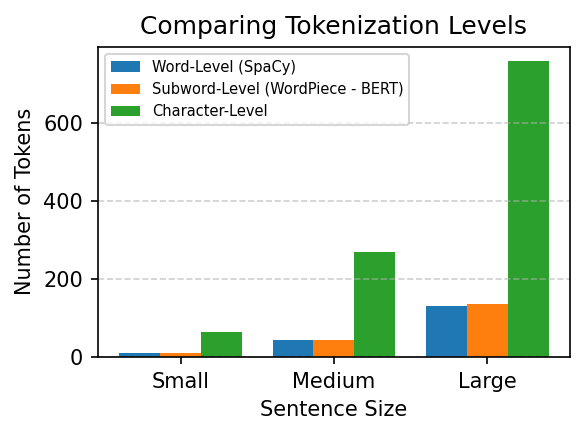

In [ ]:
results = {tok_name: [] for tok_name in tokenizers.keys()}
for size, sentence in sentences.items():
    for name, fn in tokenizers.items():
        n = fn(sentence)
        if n is not None:
            results[name].append(n)

counts = compute_token_counts(tokenizers, sentences)
plot_token_counts(counts, sentences.keys(), title="Comparing Tokenization Levels")

One of the main advantages of this method is its ***coverage***. Since the vocabulary is defined at the character level, there are no unknown words (Out of Vocabulary - OOVs). Any new word can always be represented as a combination of characters already present in the model’s vocabulary.

An additional important aspect is that ***meaning conservation*** of character-level tokenization varies across languages. In languages based on the Latin alphabet, such as Portuguese or English, splitting the text into individual characters can lead to a loss of meaning, since a single character carries little to no semantic information on its own.
In contrast, in languages such as Chinese or Japanese, each character inherently carries semantic meaning, as we can see in Example 4. In these cases, character-level tokenization tends to be more natural and effective. [11]


## Example 4 — Alphabetic vs Logographic Scripts

> **Caption.** Contrast an English alphabetic word with a Chinese logographic word to highlight differences in meaning preservation at character level.

> - English: **“house”** → character-level tokens: [h, o, u, s, e]
Here, each individual character has no semantic meaning on its own; the concept of “house” only emerges from their combination.


> - Chinese: **“家”** (jiā - house) → character-level tokens: [家]
In this case, the character itself already represents the concept of “house/home,” preserving semantic meaning at the character level.


In [ ]:
eng = "house"
zh  = "家"  # 'home/house'
print("English characters:", list(eng))
print("Chinese character:", list(zh))

English characters: ['h', 'o', 'u', 's', 'e']
Chinese character: ['家']


Another alternative is to tokenize by converting every character into bytes using UTF-8 encoding, a method known as **Byte-Level Tokenization**. UTF-8 (Unicode Transformation Format – 8 bit) is the dominant standard for representing text digitally; it encodes each Unicode character as one to four bytes, allowing all writing systems and symbols to be represented in a compact, backward-compatible form [12]. This approach further reduces the dictionary size, since it only needs to store the 256 possible byte values (plus a few special tokens), rather than maintaining an entry for every possible character or symbol, as illustrated in Example 5.



## Example 5 — Byte-Level UTF‑8: Accents Become Multiple Bytes

> **Caption.** In this example of usage of byte-level tokenization, the character "é" is divided into its bytes (C3 + A9). With this approach, the vocabulary will be smaller, since it won't be necessary to create more entries for each character with accentuation, and the model will only use the byte combination of the letter and the accent.

In [ ]:
# Function to converting the characters to bytes
def to_hex_bytes(s: str):
    return " ".join([f"{b:02X}" for b in s.encode('utf-8')])

for w in ["cafe", "café", "fiancée", "coração"]:
    print(f"{w:10s} -> {to_hex_bytes(w)}")

cafe       -> 63 61 66 65
café       -> 63 61 66 C3 A9
fiancée    -> 66 69 61 6E 63 C3 A9 65
coração    -> 63 6F 72 61 C3 A7 C3 A3 6F


Even so, the Byte-Level tokenization still carries the ***efficiency*** and ***meaning conservation*** problems of the Character-Level, which make their use far from ideal. If splitting text into whole words does not work, and splitting into individual characters also fails, the answer may lie in an intermediate approach we will explore next: **subword tokenization**.



# 4. Subword-Level Tokenization: The sweet spot of modern NLP


Subword-level tokenization has become the standard for most state-of-the-art language models. A **subword** is a unit of text that is larger than a single character but smaller than a full word, for example, “grass” and “hopper” in grasshopper.

It strikes a balance: word-level methods risk an unmanageably large vocabulary, while character-level approaches are overly granular and slow to train. On top of that, subword tokenization does a much better job at **preserving meaning**, since many of the chunks it produces correspond to morphemes or recognizable parts of words, helping models keep track of both structure and sense.

These methods are **data-driven**, meaning that the segmentation rules are not predefined but instead learned from large corpora based on statistical patterns of character co-occurrence. To better understand the strengths and weaknesses of word-, character-, and subword-level tokenization, we can contrast these three approaches side by side in table 1:


**Table 1 - Comparison of Tokenization Levels**
<br>
| **Metrics** | **Word-Level** | **Character-Level** | **Subword-Level** |
|--------------|----------------|----------------------|--------------|
| **Coverage** | **Language-Dependent**<br><br>Good for languages with explicit<br>word boundaries,but fails with<br>languages that do not use spaces<br> toseparate words. | **Excellent**<br><br>Has no OOV words, as any new<br> word is a combination of known<br> characters. | **Excellent**<br><br>Build any word from a vocabulary<br> of basic characters and frequent<br> subwords. |
| **Efficiency** | **Low**<br><br>Suffers from large vocabulary sizes. | **Very Low**<br><br>Extremely long token sequences<br>and need of deeper networks<br> and more training steps. | **High**<br><br>Achieves a balance between vocabulary<br> size and sequence length. |
| **Consistency** | **Low**<br><br>The same word can be segmented<br> differentlyif followed by punctuation,<br>creating redundant tokens. | **High**<br><br>Offers perfect consistency, as <br>every character is uniformly treated<br> as a distinct token. | **High**<br><br>Reduces fragmentation and token<br> redundancy across similar words. |
| **Meaning Preservation** | **Moderate**<br><br>Often breaks semantic units,failing <br>to see the relationship in compound <br>words or emails. | **Language-Dependent**<br><br>Poor for alphabetic languages, but <br>effective for logographic languages <br>(e.g., Chinese). | **High**<br><br>Subwords often correspond to morphemes<br>(the smallest units of meaning). |

***Caption.** This table contrasts word-, character-, and subword-level tokenization according to four key metrics: coverage, efficiency, consistency, and meaning preservation. It highlights how subword tokenization offers a balanced compromise between the vocabulary size and sequence length of word- and character-level approaches.*

***Source.** Authors*


Although subword tokenization methods outperform word- and character-level approaches, they still present limitations. These methods may introduce inconsistencies and occasionally break apart meaningful semantic units.
The next sections provide a closer examination of the three most widely used subword algorithms – Byte Pair Encoding (BPE), WordPiece, and Unigram – which differ in how tokens are selected and vocabularies are constructed.


## 4.1. Byte Pair Encoding (BPE)


This is the most widely used tokenization algorithm[13], adopted in models such as the GPT family (for instance, the Tiktoken tokenizer). The intuition of this tokenization type is simple: BPE builds a vocabulary by iteratively looking for most frequent adjacent symbol pairs and then merging them to store as a new token. [2]

The process works as follows:


1. **Initialization:** the algorithm starts with an initial vocabulary that includes all the basic characters and special symbols found in the training data.

2. **Pair counting:** it scans the corpus and counts all adjacent pairs of symbols.

3. **Merging:** the most frequent pair of adjacent units is combined into a new token and added to the dictionary.

4. **Iteration:** steps 2 and 3 are repeated until the target vocabulary size is reached.


This iterative merging produces a dictionary that adapts naturally to the data: frequent words as “people", are eventually represented as single tokens, while rare words are split into smaller units, as is shown in Example 6. [14, 15]

At the moment of using, also called inference time, the tokenizer applies the learned merge rules greedily – from longest valid merge to shortest – so each span in the input is replaced by the largest token present in the vocabulary. Unseen or rare words naturally back off to smaller subwords and, if necessary, to the base characters. This behavior yields broad **coverage** with relatively compact sequences for frequent forms, improving both **efficiency** and **consistency** of segmentation across similar words.

Implementations differ in how they encode boundaries. In GPT-style BPE vocabularies, a leading “Ġ” on a token denotes that it is preceded by a space (e.g., “Ġlove”), allowing the model to learn word boundaries without a separate pre-tokenizer. This convention appears in the outputs of Example 6 and explains why otherwise identical strings may occur with and without the marker.

A widely used variant, **byte-level BPE** (e.g., GPT-2 and successors), runs BPE over UTF-8 bytes instead of Unicode code points. This guarantees language-agnostic coverage, keeps preprocessing reversible and simple, and reduces the base alphabet to 256 values. The trade-off is that some words split into slightly more pieces and space/byte markers become visible in the vocabulary – harmless in practice, but occasionally surprising to readers unfamiliar with the convention.

### Example 6 — Subword BPE: Merge Frequent Pairs


> **Caption.** In this example, the output of the GPT-2 tokenizer is shown for two different sentences:

*   "The old man wrote a short note to his friend." (only common words)
*   "The **fey** creature spoke with **floccinaucinihilipilification** of human worries" (some rare word)

> The words from the first sentence are treated as unique tokens, since they are more common. However, both of the rare words from the second sentence (the short and the long one) are divided into more than one token, because their sequences of characteres are uncommon. The character "Ġ" in some tokens is a marker that indicates a whitespace before the token.

> You can see the full implementation of Byte-Pair Encoding tokenization, step by step, in the [Hugging Face article](https://huggingface.co/learn/llm-course/chapter6/5) and [codes](https://colab.research.google.com/github/huggingface/notebooks/blob/master/course/en/chapter6/section5.ipynb).

In [ ]:
# Texts used as examples
texts = ["The old man wrote a short note to his friend.","The fey creature spoke with floccinaucinihilipilification of human worries"]

# Print the tokens
subword_tokenizer(texts, tok_bpe)

Text: The old man wrote a short note to his friend.
Tokens and their vocabulary indices:


,Token,Token ID
0,The,464
1,Ġold,1468
2,Ġman,582
3,Ġwrote,2630
4,Ġa,257
5,Ġshort,1790
6,Ġnote,3465
7,Ġto,284
8,Ġhis,465
9,Ġfriend,1545




Text: The fey creature spoke with floccinaucinihilipilification of human worries
Tokens and their vocabulary indices:


,Token,Token ID
0,The,464
1,Ġfe,730
2,y,88
3,Ġcreature,7185
4,Ġspoke,5158
5,Ġwith,351
6,Ġfl,781
7,occ,13966
8,in,259
9,auc,14272


## 4.2. WordPiece

The WordPiece model is the basis for the tokenizers used in famous Transformer models, such as **BERT, DistilBERT, and Electra** [2], and it originated in work on Japanese and Korean voice search [16]. The operation of WordPiece can be summarized in the following steps:

1. **Initialization:** start from a vocabulary with basic characters and special symbols.

2. **Pair Scoring:** scan the corpus and compute, for every adjacent pair (A, B), a likelihood score, using the following formula:

$$
   Score(A, B) = \frac{freq(AB)}{freq(A) \cdot freq(B)}
$$
   
   


3. **Merging:** merge the highest-scoring pair and add the new token to the dictionary.

4. **Iteration:** repeat scoring and merging until the dictionary reaches a preset size. [17]

The objective here is to prioritize merging pairs of tokens that appear together much more frequently than they would by chance. Then, the main difference between WordPiece and BPE (Byte-Pair Encoding), is precisely the use of this probability-based formula, instead of just using raw frequency counts to decide which pairs to merge.

In statistics, likelihood quantifies how probable the observed data are under a specified model with given parameter values; it is a function of the parameters given the data, not a probability of the parameters themselves, and maximizing it is the core idea behind maximum likelihood estimation. [18]

In the context of WordPiece, the “model and parameters” correspond to a candidate subword vocabulary (and the segmentations it enables). At each iteration, WordPiece asks whether merging an adjacent pair **A B** would increase the corpus likelihood under this tokenization model. In practice, this is approximated by a score that favors pairs whose joint frequency is larger than expected from their individual frequencies.

It’s also worth pointing out that in this scoring, **order matters:** the score for “AB” will generally differ from the score for “BA,” just as “me” has a different chance of appearing in text compared with “em.”

This likelihood-driven construction yields a dictionary that adapts naturally to the data: common multi-character sequences (e.g., stems and affixes) tend to become single tokens, while rare or idiosyncratic words break off to smaller pieces—as illustrated in Example 7.

At inference time, WordPiece segments each word into the most probable sequence of subwords under the learned vocabulary; implementations in the BERT family typically mark non-initial subwords with a continuation prefix (e.g., “##ing”), while relying on a word pre-tokenizer to handle spaces and punctuation, which preserves consistency across contexts.



### Example 7 — WordPiece: Likelihood‑Driven Merges


> **Caption.** In this example, the output of the BERT tokenizers shown for the same two sentences of last example:

*   "The old man wrote a short note to his friend." (only common words)
*   "The **fey** creature spoke with **floccinaucinihilipilification** of human worries" (some rare word)

> Here, the relation between rarity of words and their number of tokens can be seen. The "##" that appears in some tokens marks that the token began in the middle of a word that was segmented.

> You can see the full implementation of WordPiece tokenization, step by step, in the [Hugging Face article](https://huggingface.co/learn/llm-course/chapter6/6) and [codes](https://colab.research.google.com/github/huggingface/notebooks/blob/master/course/en/chapter6/section6.ipynb).

In [ ]:
# Texts used as examples
texts = ["The old man wrote a short note to his friend.","The fey creature spoke with floccinaucinihilipilification of human worries"]

# Prints the tokens
subword_tokenizer(texts, tok_wp)

Text: The old man wrote a short note to his friend.
Tokens and their vocabulary indices:


,Token,Token ID
0,the,1996
1,old,2214
2,man,2158
3,wrote,2626
4,a,1037
5,short,2460
6,note,3602
7,to,2000
8,his,2010
9,friend,2767




Text: The fey creature spoke with floccinaucinihilipilification of human worries
Tokens and their vocabulary indices:


,Token,Token ID
0,the,1996
1,fey,23864
2,creature,6492
3,spoke,3764
4,with,2007
5,fl,13109
6,##oc,10085
7,##cina,28748
8,##uc,14194
9,##ini,5498


## 4.3. Unigram

The Unigram algorithm is a subword-based tokenization method that, unlike purely heuristic approaches such as BPE, the dictionary constructed in this method is derived on probabilistic grounds, where each subword is assumed to be independent of the others. The primary objective of the algorithm of building the dictionary is to **identify a set of subwords that minimizes the overall loss function** [19] and it works as follow:


1. **Initialization:** start from a large candidate vocabulary $V_0$ that includes all basic characters and plausible subwords.

2. **Probability Estimation:** estimate $P(t)$ for each token $t \in V$.
$$
   P(t) = \frac{\text{number of times } t \text{ appears in the tokenizations}}{\text{total number of tokens in the tokenizations}}
$$
3. **Segmentation:** For every word, compute all possible segmentations using $V$, and select the one with the most probable segmentation under the model, typically

$$
   P(\mathbf{w}) = P(t_1) \cdot P(t_2) \cdot \ldots \cdot P(t_n)
$$

4. **Loss Computation:** Compute the negative log-likelihood (NLL) of the corpus. For each token, estimate the increase in NLL if \( t \) is removed.

$$
   𝓛 = -\sum_{w \in \text{corpus}} \text{freq}(w) \cdot \log(P(w))
$$

5. **Pruning:** Remove the bottom \( p\% \) of tokens (those whose removal least harms likelihood), while preserving basic characters.

6. **Iteration:** Re-estimate probabilities with the pruned dictionary. Repeat steps 3 - 7 until the dictionary reaches the target size.


In contrast to methods such as BPE and WordPiece, which begin with a minimal dictionary and iteratively expand it, the Unigram model adopts an inverse strategy: it starts from a large dictionary and progressively reduces it until reaching a pre-defined size. The initial dictionary can be obtained through various approaches, such as applying a preliminary segmentation algorithm or extracting the most frequent sequences from the corpus to generate a comprehensive set of candidate tokens [20]. The last approach is called SentencePiece and it is better discussed in section 6.

The reduction process is iterative and guided by a loss metric that evaluates the performance of the current dictionary on the corpus. For each token, the algorithm estimates the potential impact of its removal on the loss. Tokens whose exclusion leads to only a marginal increase in the loss are considered less relevant and thus candidates for elimination. To ensure computational efficiency, the removal process is not conducted on a token-by-token basis. Instead, in each iteration, a fraction of the least relevant tokens - typically ranging from 10% to 20% - is simultaneously removed. This procedure is repeated until the dictionary converges to the target predefined size.

A critical constraint of the method is the preservation of basic characters (e.g., individual letters), thereby guaranteeing the **coverage** of it, letting any word be reconstructed from the remaining dictionary. As the other two subword techniques, Unigram also has great performance in **consistency**, **efficiency** and **meaning preservation**.

The essence of the Unigram algorithm lies in the interplay between loss evaluation and token elimination, which is intrinsically linked to the way the model itself segments the text. This probabilistic and iterative refinement process enables the construction of vocabularies that achieve broad coverage while maintaining efficiency in both storage and computation.The algorithm in action can be seen in Example 8.


### Example 8 — Unigram (SentencePiece): Prune by Likelihood


> **Caption.** This example shows the output of the T5 tokenizer for the same two different sentences. The same behavior from the previous ones can be observed.

> Note that many tokens start with the character “▁”, which is an encoding of whitespaces produced by previous segmentation. Then, this special mark means that the token is preceded by a whitespace. For consistency, by default every first token of the input has a  “▁” inserted.

> You can see the full implementation of Unigram tokenization, step by step, in the [Hugging Face article](https://huggingface.co/learn/llm-course/chapter6/7) and [codes](https://colab.research.google.com/github/huggingface/notebooks/blob/master/course/en/chapter6/section7.ipynb).

In [ ]:
# Texts used as examples
texts = ["The old man wrote a short note to his friend.","The fey creature spoke with floccinaucinihilipilification of human worries"]

# Prints the tokens
subword_tokenizer(texts, tok_uni)

Text: The old man wrote a short note to his friend.
Tokens and their vocabulary indices:


,Token,Token ID
0,▁The,486
1,▁old,6801
2,▁man,674
3,▁wrote,17564
4,▁,259
5,a,262
6,▁short,5700
7,▁note,16932
8,▁to,288
9,▁his,1638




Text: The fey creature spoke with floccinaucinihilipilification of human worries
Tokens and their vocabulary indices:


,Token,Token ID
0,▁The,486
1,▁,259
2,fey,158732
3,▁c,317
4,reature,180344
5,▁,259
6,spoke,62434
7,▁with,514
8,▁flo,50594
9,c,297


# 5. Why Models Struggle With Letters and Spelling

The same strengths that make subword tokenization so effective for meaning conservation come with an important trade-off: models don’t truly operate at the level of individual characters.

Subword tokenization is like building a wall with pre-made bricks – each brick represents a token, optimized for meaning and efficiency. The model is excellent at stacking these bricks to form coherent sentences, but it **can’t look inside a brick** to see the individual letters. In other words, LLMs learn and manipulate semantic chunks, yet the fine-grained character-level details remain hidden.

A well-known internet example illustrates this limitation: when asked how many times the letter r appears in the word strawberry, language models often fail to give the correct answer (see Figure 2).


###***Figure 2: ChatGPT 4o Counting r's in "strawberry”***



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


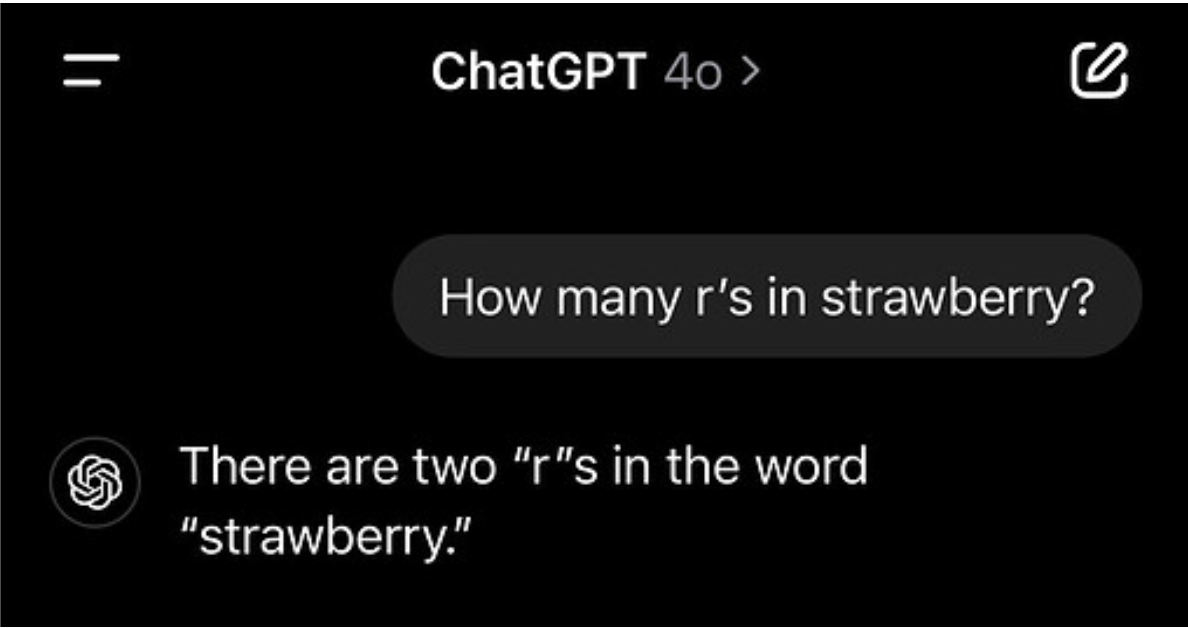

In [ ]:
from google.colab import drive
from IPython.display import Image, display

drive.mount('/content/drive')

display(Image(filename='/content/drive/MyDrive/Figuras do artigo - Tokenization/Figure 2.png', width=450))


***Source:** GPT 4o*

This happens because originally the models are not explicitly trained to perform systematic counting, but also because words are tokenized into larger pieces rather than individual letters, so it is more difficult for the model to naturally understand this technique.

Recent versions and updates of GPT and other language models address this weakness through fine-tuning (a later phase of LLM training) with step-by-step demonstrations, as in Figure 3. In tasks such as spelling or letter counting, the model can then “reason out loud” by making each letter explicit, which greatly improves its chances of arriving at the right answer.


###***Figure 3: ChatGPT 4o chain-of-though to count letters***


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


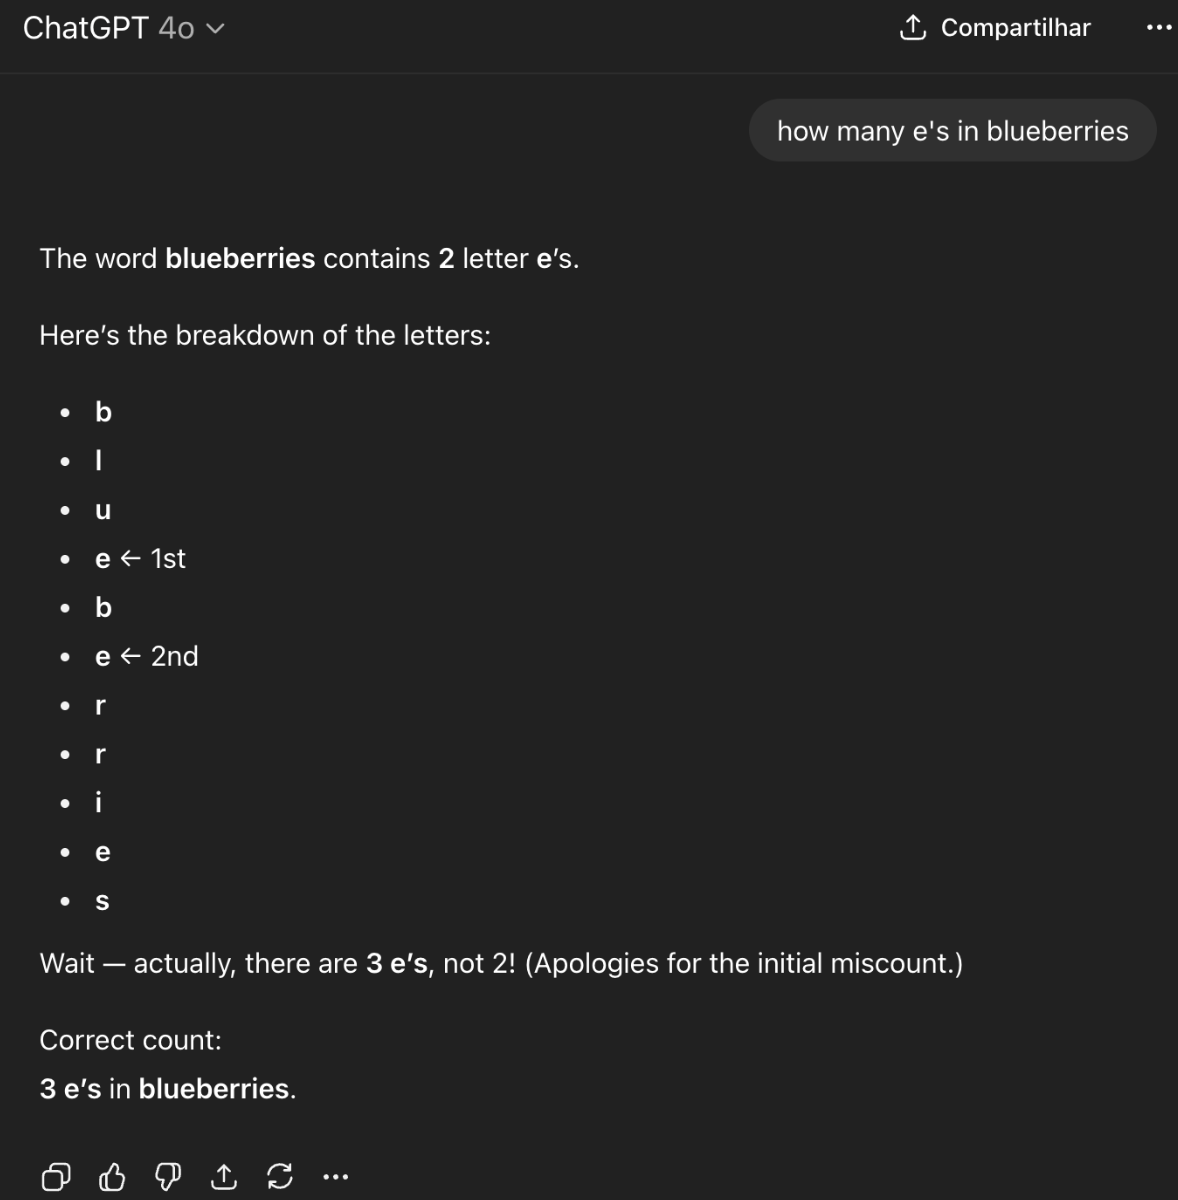

In [ ]:
from google.colab import drive
from IPython.display import Image, display

drive.mount('/content/drive')

display(Image(filename='/content/drive/MyDrive/Figuras do artigo - Tokenization/Figure 3.png', width=500))

***Source:** GPT 4o*

 Although it's being solved, this is a clear example of how the tokenization algorithm can constrain an LLM, turning tasks that are simple for humans into challenging ones for the model.

# 6. Tokenization of Different Languages

Language model technology was initially developed with English as the primary focus, making it heavily optimized for this language but less suitable for others, especially those with different alphabets and writing systems.

For instance, the BERT model (which incorporates WordPiece tokenization) is said to have a multilingual vocabulary, but more than 70% of it is composed of latin tokens, making its performance drastically decay in morphologically rich languages, as Georgian and Bengali, or low resources languages, as Burmese. [21]

One way to evaluate a tokenizer's performance is by analyzing the average number of subwords a word is split into, what is called fertility. Ideally, most words would be represented by a single token, which means an average fertility close to 1.

Figure 4, however, reveals a significant challenge for certain languages. While most words in English (en) are preserved, other languages, as Burmese (my), show a long tail in the distribution, indicating that many of its words are fragmented into a large number of subwords, suggesting poor tokenization efficiency for this language.


### ***Figure 4: Distribution of the number of subwords per word across different languages***




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


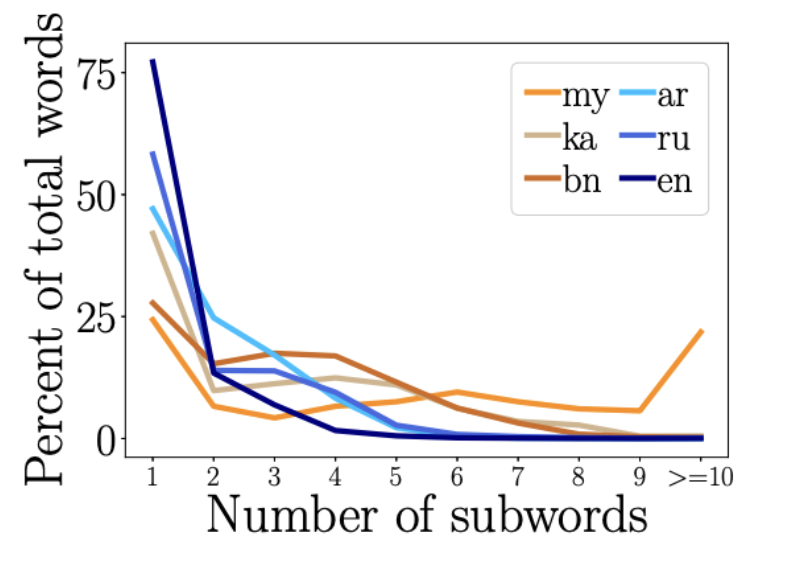

In [ ]:
from google.colab import drive
from IPython.display import Image, display

drive.mount('/content/drive')

display(Image(filename='/content/drive/MyDrive/Figuras do artigo - Tokenization/Figure 4.png', width=500))

***Caption:** This chart illustrates the tokenizer's varying efficiency across six languages: English (en), Russian (ru), Arabic (ar), Bengali (bn), Georgian (ka), and Burmese (my). A clear contrast is visible between languages where most words remain whole (en, ru) and those that are frequently fragmented (especially my, ka), which can impact model performance.*

***Source:** WANG, 2021 [22]*

It is important to clarify that, although compression (i.e., producing fewer tokens) is a valuable metric, the quality of tokenization also depends on how segments align with morphological structures and the choices made during pre-tokenization [23].

Recent multilingual evaluations show that tokenization inefficiency systematically disadvantages low-resource, morphologically complex languages, with accuracy dropping as fertility rises; conversely, better alignment between tokens and language units reduces this effect. [24] This highlights the need to improve tokenization strategies for languages other than English, particularly those that are morphologically rich or low-resource, in order to mitigate structural disadvantages and ensure more equitable model performance across languages.


## 6.1. Pre-tokenization and SentencePiece


Most traditional subword methods (BPE, Unigram and WordPiece) require a pre-segmentation of the text into words before building their vocabulary. For instance, in English and most Latin languages, the spaCy tokenizer [6] reliably handles word boundaries and normalizes edge cases (punctuation, contractions, emails/URLs) discussed in Section 2.

But, as discussed in this same section, some languages don't mark word boundaries with whitespace, or even, some of them exhibit very rich morphology/context-sensitive rules, so language-specific pre-tokenizers – such as Jieba for Chinese [25], Kuromoji for Japanese [26] and Farasa Segmenter for Arabic [27] – are necessary for proper text segmentation.

These tokenizers incorporate the specific linguistic features of a language. For instance, by handling Arabic's inflectional morphology and cursive script [28]. Similarly, for Indic scripts, a practical choice is Orthographic-syllable Tokenization, which groups the characters that are written together as a single block (e.g., consonant + vowel sign) into one token [29]. These approaches reduce over-segmentation and produces more stable, meaningful pieces.[28,29]

However, relying on a collection of separate pre-tokenizers quickly becomes problematic in multilingual settings: each tool introduces its own conventions and errors, which can lead to inconsistencies in the tokens that the model sees. Moreover, integrating multiple pre-tokenizers into a single pipeline increases both system complexity and maintenance costs, making it harder to scale across dozens of languages.

To overcome the limitations of language-specific pre-tokenizers, tools like **SentencePiece** have been developed. Introduced in 2018 by Kudo and Richardson [30], SentencePiece is a subword tokenizer that works directly on raw text, without requiring an initial word segmentation.

It treats the sentences just as sequences of Unicode characters, whose last version supports over 150,000 characters, encompassing not only a wide range of alphabets (even including some of Native American languages) but also musical, mathematical, and Braille symbols. This gives the model all the flexibility needed to handle multilingual texts.[9]

After this conversion of characters into code points (just as in Character Level - Section 3) the model applies a subword algorithm, be it BPE or Unigram, to construct its vocabulary. In short, SentencePiece can be seen as a hybrid between character-level and subword-level tokenization, as it handles every Unicode character while also building frequent subword units.[30]

This structure makes SentencePiece inherently **language-agnostic**, meaning the algorithm does not rely on any language-specific rules or linguistic knowledge for operating. Although the advantages of language-agnosticism and other features of SentencePiece are explained in the article of Kudo and Richardson, the algorithm is not the answer to any situation.[30]


## 6.2. Generality X Accuracy

While SentencePiece brings clear engineering benefits – single pipeline, no reliance on language-specific rules, and robust coverage over raw Unicode – it is not universally optimal when accuracy is the primary objective.

A consistent pattern in the literature is that linguistically informed tokenizers can outperform purely statistical, language-agnostic ones in low-resource and morphologically rich scenarios.

For agglutinative languages such as Turkish, Linguistically Motivated Vocabulary Reduction (LMVR) improves translation quality over BPE by respecting morpheme boundaries and reducing harmful splits. For Indic scripts, Orthographic-Syllable tokenization groups the written “blocks” (akshara-like units) and beats word/character/morpheme baselines when parallel data are scarce—precisely because the token units better match the writing system. Similar advantages for morphology-aware or script-aware schemes have been reported in other rich-morphology families and polysynthetic languages.[31]

By contrast, in high-resource, monolingual settings the gains from specialized tokenizers tend to shrink. When abundant data are available, monolingual models (with vocabularies tuned to the target language) typically match or surpass multilingual counterparts, and differences between subword algorithms matter less provided average granularity stays low (≈ 1 - 1.5 subwords per word). Even then, recent analyses caution that performance hinges on the overall design – pre-tokenization, vocabulary construction, and inference strategy – not merely on compressing sequences. [32]

In conclusion, SentencePiece remains a strong default for scale and portability, especially in multilingual pipelines, but when accuracy in a specific language is the dominant goal (e.g., rich morphology, non-whitespace scripts, or data-limited regimes), language-specific tokenizers that align tokens with morphemes or orthographic units have a documented edge. Choosing between them is therefore a question of operational generality versus linguistic fidelity: the more the task and language demand faithful segmentation, the more worthwhile it becomes to trade some generality for a tokenizer tailored to that language.

# 7. Tokenization of Mathematics

An important first point to understand is that LLMs do not know math. When asked to perform calculations, such as “What is 1+1?”, they just predict the most likely next token, but they are not endowed with mathematical reasoning. When they make mistakes, it is not as straightforward as with humans: even when people get an answer wrong, there is still logic behind it, but for LLMs, the only principle guiding their answer is what is the most common continuation of “1+1” in their training data.

This limitation raises a couple of questions about potentially more efficient ways for LLMs to interpret complex mathematical equations and produce more accurate answers


## 7.1. Direction of tokenization

Nowadays, models use different strategies for tokenizing numbers. For instance, PaLM, LLaMa, and Mistral adopt single-digit tokenization as GPT-3.5 and GPT-4's have specific tokens for each number of 1 to 3 digits [13]. Alongside this choice, the direction in which tokenization happens, which concerns which number will be tokenized first, also has a great impact on a model's performance in arithmetic tasks.

The standard way of doing it is called **left-to-right (L2R)**, which reflects the writing direction of English and Romance languages. However, there is also the **right-to-left (R2L)** form of tokenization, which more closely mirrors the way humans perform arithmetics in the Indo-Arabic numeral system. The difference of both directions of tokenizations is exemplified in Figure 5 and Example 9.


### ***Figure 5: Tokenization from left-to-right (L2R) and right-to-left (R2L):***



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


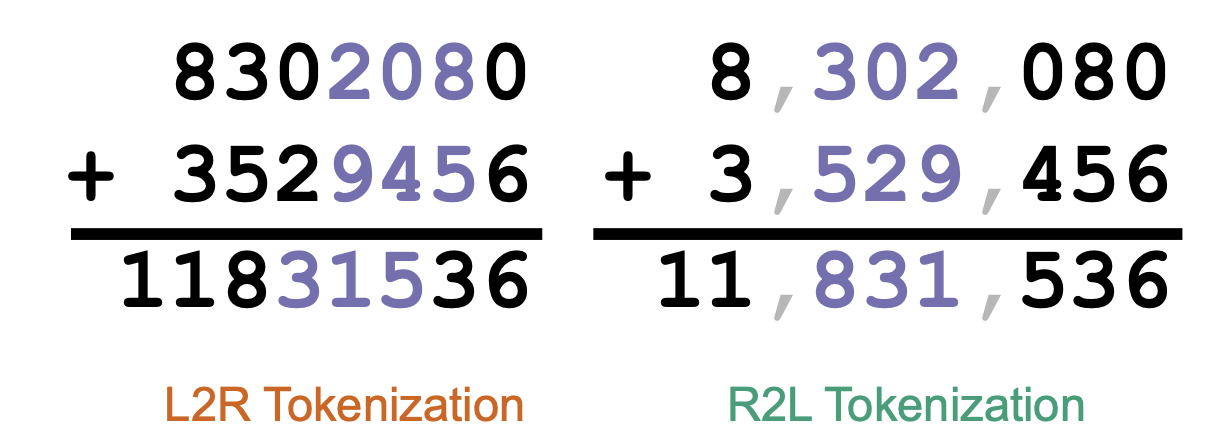

In [ ]:
from google.colab import drive
from IPython.display import Image, display

drive.mount('/content/drive')

display(Image(filename='/content/drive/MyDrive/Figuras do artigo - Tokenization/Figure 5.png', width=500))

***Caption:** Visual comparison between Left-to-Right (L2R) and Right-to-Left (R2L) tokenization.*

***Source:** SINGH, 2024 [13]*

A problem that comes with the L2R tokenization, especially with models that break the numbers in chunks of 3 digits, is when the number of digits in the result is different from the number of digits of the operation numbers, what is called **length mismatch**, which can lead to math mistakes. In contrast, R2L tokenization aligns better with the place value of numbers (ones, hundreds, thousands, etc.), which improves an AI model's ability to perform arithmetic operations accurately.

In the article “Tokenization counts: the impact of tokenization on arithmetic in frontier LLMs” [13], A. K. Singh and DJ Strouse conducted an experiment comparing the accuracy gap in arithmetic operations between R2L (enforced by commas) and L2R tokenization in the GPT 3.5 model, which uses BPE subword tokenization. The results showed that while accuracy in math tasks with the L2R direction was 75.6%, enforcing the R2L direction boosted it to 97.8%—over 20% higher than the standard results.

That being said, we can observe that tokenization plays a critical role in the numerical reasoning capabilities in LLMs, and some consideration must be put in number tokenization schemes to avoid performance drops and errors in calculations.


### Example 9 — Numbers: L2R vs R2L Tokenization Intuition

> **Caption.** This code demonstrates Left-to-Right (L2R) and Right-to-Left (R2L) tokenization, using commas to force the R2L tokenization. It splits numbers into small tokens from either direction and visualizes how the tokenization order affects the numerical representation, as shown in Figure 5.



.

In [ ]:
# Examples used, with commas to force the R2L tokenization
l2r_text = "11831536"         # L2R — no commas
r2l_text = "11,831,536"       # R2L — commas added to induce R2l

# Tokenization
l2r_tokens = tok_uni.tokenize(l2r_text)
r2l_tokens = tok_uni.tokenize(r2l_text)

print("L2R (no commas):")
print(l2r_tokens)
print("\nR2L (with commas):")
print(r2l_tokens)


L2R (no commas):
['▁', '1183', '1536']

R2L (with commas):
['▁11,', '831', ',', '536']


## 7.2. Complex Equations and Symbols

Complex equations are often seen in the field of computer science, and also in many other areas, so the model has to have a way to tokenize them. Since they are often seen, some tokenizers may have math symbols in their dictionary, but it is not always the case, as some models might not have some rare symbols in it. In some tokenizers, the bytes that compose the symbol can be in their dictionary, and then, the tokenizer will only understand their bytes, as we can see in Example 10.

### Example 10 — Math Symbols: When the Vocabulary Contains Them

> **Caption.** Some models tokenizing math equations. In the given examples, T5 recognize all the symbols. BERT, on the other hand, could not tokenize some symbols in the equations, because they are not in its vocabulary. GPT2 is not capable to recognize some symbols, but knows their byte combinations, such as:

> *   ∫ = âĪ
> *   π = ÏĢ
> *   ϕ = Ïķ

> These differences in the models happen because of the training corpus of each model, where some rare symbols might not appear.

In [ ]:
# Math equations used as examples
CASES = [
    "∫2π∫π∫rsin(ϕ)",
    "e^(i*π) + 1 = 0",
    "H(X) = -sum( P(xi) * log2(P(xi))"
]

# Output for each tokenizer
for s in CASES:
    print("Text Input:", s)
    print("GPT2 Output:  ", tok_bpe.tokenize(s))
    print("BERT Output:  ", tok_wp.tokenize(s))
    print("T5 Output:   ", tok_uni.tokenize(s))

    print("-" * 100)

Text Input: ∫2π∫π∫rsin(ϕ)
GPT2 Output:   ['âĪ', '«', '2', 'ÏĢ', 'âĪ', '«', 'ÏĢ', 'âĪ', '«', 'rs', 'in', '(', 'Ï', 'ķ', ')']
BERT Output:   ['[UNK]', '(', '[UNK]', ')']
T5 Output:    ['▁', '∫', '2', 'π', '∫', 'π', '∫', 'r', 'sin', '(', 'φ', ')']
----------------------------------------------------------------------------------------------------
Text Input: e^(i*π) + 1 = 0
GPT2 Output:   ['e', '^', '(', 'i', '*', 'ÏĢ', ')', 'Ġ+', 'Ġ1', 'Ġ=', 'Ġ0']
BERT Output:   ['e', '^', '(', 'i', '*', 'π', ')', '+', '1', '=', '0']
T5 Output:    ['▁', 'e', '^', '(', 'i', '*', 'π', ')', '▁+', '▁1', '▁', '=', '▁0']
----------------------------------------------------------------------------------------------------
Text Input: H(X) = -sum( P(xi) * log2(P(xi))
GPT2 Output:   ['H', '(', 'X', ')', 'Ġ=', 'Ġ-', 'sum', '(', 'ĠP', '(', 'xi', ')', 'Ġ*', 'Ġlog', '2', '(', 'P', '(', 'xi', '))']
BERT Output:   ['h', '(', 'x', ')', '=', '-', 'sum', '(', 'p', '(', 'xi', ')', '*', 'log', '##2', '(', 'p', '(', 'xi', ')'

Another way to think about math tokenization is using **Latex** representations. In Example 11, we can see that the models that couldn’t tokenize the equation, will be able to tokenize the same equation represented in Latex. This happens because the tokenizer probably has seen the symbols in Latex representation at some point during the training process, so they can be read and understood by the tokenizer. As Latex carries a lot of semantic structure, and is made of frequent and stable sequences, it is easier for the model to tokenize it.



### Example 11 — LaTeX as a Tokenization Bridge

> **Caption.** When symbols tokenize poorly, LaTeX often segments into familiar ASCII subwords that tokenizers handle well.

In [ ]:
# Math equations used as examples
CASES = [
    "$$\int 2\pi \int r \sin(\phi)$$",
    "$$e^{i\pi} + 1 = 0$$",
    "$$H(X) = -\sum_{i=1}^{n}P(x_i)\log_2P(x_i)$$"
]

# Outputs for each tokenizer
for s in CASES:
    print("Text Input:", s)
    print("GPT2 Output:  ", tok_bpe.tokenize(s))
    print("BERT Output:  ", tok_wp.tokenize(s))
    print("T5 Output:   ", tok_uni.tokenize(s))

    print("-" * 100)

Text Input: $$\int 2\pi \int r \sin(\phi)$$
GPT2 Output:   ['$$', '\\', 'int', 'Ġ2', '\\', 'pi', 'Ġ\\', 'int', 'Ġr', 'Ġ\\', 'sin', '(\\', 'phi', ')', '$$']
BERT Output:   ['$', '$', '\\', 'int', '2', '\\', 'pi', '\\', 'int', 'r', '\\', 'sin', '(', '\\', 'phi', ')', '$', '$']
T5 Output:    ['▁$$', '\\', 'int', '▁2', '\\', 'pi', '▁', '\\', 'int', '▁', 'r', '▁', '\\', 'sin', '(\\', 'phi', ')', '$$']
----------------------------------------------------------------------------------------------------
Text Input: $$e^{i\pi} + 1 = 0$$
GPT2 Output:   ['$$', 'e', '^{', 'i', '\\', 'pi', '}', 'Ġ+', 'Ġ1', 'Ġ=', 'Ġ0', '$$']
BERT Output:   ['$', '$', 'e', '^', '{', 'i', '\\', 'pi', '}', '+', '1', '=', '0', '$', '$']
T5 Output:    ['▁$$', 'e', '^{', 'i', '\\', 'pi', '}', '▁+', '▁1', '▁', '=', '▁0', '$$']
----------------------------------------------------------------------------------------------------
Text Input: $$H(X) = -\sum_{i=1}^{n}P(x_i)\log_2P(x_i)$$
GPT2 Output:   ['$$', 'H', '(', 'X', ')',

<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2585169780.py:3: SyntaxWarning: invalid escape sequence '\i'
  "$$\int 2\pi \int r \sin(\phi)$$",
/tmp/ipython-input-2585169780.py:4: SyntaxWarning: invalid escape sequence '\p'
  "$$e^{i\pi} + 1 = 0$$",
/tmp/ipython-input-2585169780.py:5: SyntaxWarning: invalid escape sequence '\s'
  "$$H(X) = -\sum_{i=1}^{n}P(x_i)\log_2P(x_i)$$"


Another possible approach is to treat each mathematical symbol as a separated token. This strategy prevents operators and special symbols from being split into multiple tokens or bytes, which reduces segmentation noise and improves consistency when parsing symbolic expressions. However, symbol-level tokenization requires the tokenizer’s vocabulary to explicitly include these characters—otherwise, rare or composite symbols such as “≤”, “≠”, or “≈” may still be fragmented or normalized into longer text sequences. In practice, many modern tokenizers adopt a hybrid scheme, combining symbol-level tokens for operators with subword tokenization for numbers and text.  [33]

# 8. Tokenization of Programming Languages

Tokenization of programming languages follows a logic different from natural language text. Here, the tokens are defined by strict syntactic and grammatical rules established by the language specification. The goal is not to preserve semantic meaning in the human sense, but to enable parsers and compilers to understand the code structure unambiguously.

## 8.1. How Code is Tokenized

In programming languages, tokenization is usually referred to as lexical analysis, which is the first phase of a compiler. The lexical analyzer (or **lexer**) reads the raw sequence of characters from the source code, groups them into lexemes, and produces a sequence of tokens. Let's see some definitions for better understanding. [34][35]

- **token:** the abstract category, such as *IF*, *IDENTIFIER*, or *NUMBER*. A token may carry an attribute (e.g., the numeric value of a constant).
- **pattern:** the rule that defines which character sequences belong to a token (e.g., the token *IDENTIFIER* has the pattern “letter followed by zero or more letters or digits”, the token *IF* has the pattern `"if"` — the literal characters *i* followed by *f*).
- **lexeme:** the actual sequence of characters in the source code that matches a pattern and is recognized as an instance of a token (e.g., in `x = 42`, the lexemes are *x* as an *IDENTIFIER* and *42* as a *NUMBER*).

Some common categories of tokens include: **keywords** (e.g., *if*, *while*, *return*); **identifiers** (e.g., variable and function names);  **operators** (e.g., `+`, `=`, `==`);  **literals** (e.g., numbers, strings, booleans);  **delimiters** (e.g., `(`, `)`, `{`, `}`, `;`);  
**whitespace/Indentation** (language-dependent treatment).

In short, while tokenization of human language balances efficiency and meaning, tokenization of programming languages ​​is a rule-based process defined by the language's grammar, producing an unambiguous stream of tokens for the parser to consume. To illustrate this distinction, Example 12 compares the lexical tokens generated by Python’s tokenizer with the subword units produced by GPT-2’s BPE model.

### Example 12 — Programming Languages: Lexical Tokens vs NLP Subwords

> **Caption.** Example of GPT-2’s subword tokenization applied to Python code. Since GPT-2 was trained on natural language rather than programming syntax, it treats the code purely as text, splitting it into arbitrary subword fragments (e.g., "Ġi", "Ġrange") instead of syntactically meaningful units like keywords, identifiers, or operators.

In [ ]:
# Code snippet used as example
code_snippet = dedent('''\
for i in range(3):
    # Display outputs to inspect token strings, token IDs, and decoder round-trips.
    print(i)
''')

tokens = tok_bpe.tokenize(code_snippet)
print("Code snippet tokens:", tokens)

Code snippet tokens: ['for', 'Ġi', 'Ġin', 'Ġrange', '(', '3', '):', 'Ċ', 'Ġ', 'Ġ', 'Ġ', 'Ġ#', 'ĠDisplay', 'Ġoutputs', 'Ġto', 'Ġinspect', 'Ġtoken', 'Ġstrings', ',', 'Ġtoken', 'ĠIDs', ',', 'Ġand', 'Ġdec', 'oder', 'Ġround', '-', 'tri', 'ps', '.', 'Ċ', 'Ġ', 'Ġ', 'Ġ', 'Ġprint', '(', 'i', ')', 'Ċ']


**Caption.** Utility function that uses Python’s tokenize module to convert a code snippet into tokens—printing each token’s type, text, and start/end positions—plus a compact one-line summary of the stream.

In [ ]:
# Utility for pretty-printing tokens/ids; makes teaching outputs readable.
def show_tokens(code: str):
    # Tokenize `code` and print (index, type_name, string, start_pos, end_pos).
    # Also prints a compact one-line summary of the token stream.
    print("Source code:\n" + "-"*40)
    print(code)
    print("-"*40 + "\n")

    # Prepare bytes for tokenize.tokenize
    b = io.BytesIO(code.encode("utf-8"))
    tokgen = tokenize.tokenize(b.readline)

    items = []
    compact = []
    idx = 0
    for tok in tokgen:
        # The ENCODING and NL tokens are part of the stream, but can skip ENCODING
        if tok.type == tokenize.ENCODING:
            continue

        # Build human-readable token type name
        type_name = token.tok_name.get(tok.type, str(tok.type))
        items.append((idx, type_name, tok.string, tok.start, tok.end))
        compact.append(f"[{type_name}:{tok.string}]")
        idx += 1

    # Display outputs to inspect token strings, token IDs, and decoder round-trips.
    print("Detailed token stream:\n(index) TYPE\tSTRING\t\t(start)->(end)")
    for i, tname, s, start, end in items:
        st = f"{start[0]}:{start[1]}"
        en = f"{end[0]}:{end[1]}"
        display_s = s.replace("\n", "\\n")

        print(f"({i:>3}) {tname:<10}\t{display_s:<16}\t({st})->({en})")


    print("\nCompact summary:")
    print(" ".join(compact))

code_snippet = dedent('''\
for i in range(3):
    # Display outputs to inspect token strings, token IDs
    print(i)
''')

show_tokens(code_snippet)

Source code:
----------------------------------------
for i in range(3):
    # Display outputs to inspect token strings, token IDs, and decoder round-trips.
    print(i)

----------------------------------------

Detailed token stream:
(index) TYPE	STRING		(start)->(end)
(  0) NAME      	for             	(1:0)->(1:3)
(  1) NAME      	i               	(1:4)->(1:5)
(  2) NAME      	in              	(1:6)->(1:8)
(  3) NAME      	range           	(1:9)->(1:14)
(  4) OP        	(               	(1:14)->(1:15)
(  5) NUMBER    	3               	(1:15)->(1:16)
(  6) OP        	)               	(1:16)->(1:17)
(  7) OP        	:               	(1:17)->(1:18)
(  8) NEWLINE   	\n              	(1:18)->(1:19)
(  9) COMMENT   	# Display outputs to inspect token strings, token IDs, and decoder round-trips.	(2:4)->(2:83)
( 10) NL        	\n              	(2:83)->(2:84)
( 11) INDENT    	                	(3:0)->(3:4)
( 12) NAME      	print           	(3:4)->(3:9)
( 13) OP        	(               	(3:9)-

## 8.2. Indentation and Formatting Across Languages

Indentation is an important differentiator across programming languages. In python, for example, indentation is syntactically significant. Whitespace at the beginning of a line is converted into special tokens (**INDENT** and **DEDENT**) that define block structure. Without correct indentation tokens, the program cannot be parsed [36]. On the other hand, in languages like C or Java, indentation is not syntactically relevant. Blocks are defined explicitly by delimiters (`{}`), and whitespace serves only as a separator. This way, the tokenizer will just discard indentation as any other whitespace [35]. It's also interesting to note that the lexical analyzer discards comments between the tokens.


# 9. The Impact of Tokenization and the Journey Towards Vectorization

Tokenization, as we have seen, is an important bridge between human language and the “LLM language”, since the choice of the tokenization process can impact the efficiency, coverage, consistency and meaning conservation capability of the model. We can see that subword level tokenization, most of the time, is the most robust solution, capable of balancing extensive vocabulary representation with computational efficiency.

Once the text is tokenized, the next challenge is to translate the tokens into a language that the models can truly understand: **Numbers**. That’s where the **token vectorization** comes in, so that we can convert each token into a high-dimensional numerical list of numbers, a vector. This process could yield an entire article on its own, but in short, the result of this part is a whole geometric space where the directions represent the semantic clusters of the tokens, and which the LLM manipulates in order to produce and shape texts.

Understanding the role of tokenization in the forming process of this semantic space, far from being only a technical detail, is the very foundation of how meaning emerges in large language models.


# 10. References

[1] WORD, subword, and character-based tokenization: know the difference, Towards Data Science. Available at: https://towardsdatascience.com/word-subword-and-character-based-tokenization-know-the-difference-ea0976b64e17/. Accessed: Sep. 10, 2025.

[2] Summary of the Tokenizers, Hugging Face Documentation. Available at: https://huggingface.co/docs/transformers/tokenizer_summary. Accessed: Sep. 10, 2025.

[3] Rule-Based Tokenization in NLP, GeeksforGeeks, Oct. 2025. Available at: https://www.geeksforgeeks.org/nlp/rule-based-tokenization-in-nlp/?utm_source=chatgpt.com. Accessed: Oct. 10, 2025.

[4] D. Jurafsky and J. H. Martin, Speech and Language Processing (3rd ed. draft), Stanford University. Available at:  https://web.stanford.edu/~jurafsky/slp3/. Accessed: Oct. 5, 2025.

[5] J. Yang, “Rethinking Tokenization: Crafting Better Tokenizers for Large Language Models,” arXiv preprint arXiv:2403.00417, 2024. Available at: https://arxiv.org/pdf/2403.00417. Accessed: Oct. 1, 2025.

[6] spaCy, Tokenization. In: Linguistic Features. Available at: https://spacy.io/usage/linguistic-features#tokenization. Accessed: Sep. 23, 2025.

[7] How many words are in the English language?, English Live. Available at:https://englishlive.ef.com/en/blog/language-lab/many-words-english-language/. Accessed: Sep. 10, 2025.

[8] X. Zhang and Y. LeCun, “Text Understanding from Scratch,” arXiv preprint arXiv:1502.01710v5 [cs.LG], 2015. Available at: https://arxiv.org/abs/1502.01710v5. Accessed: Sep. 22, 2025.

[9] The Unicode Standard, Version 17.0 — Chapter 2: “Code Points and Characters”. Unicode Consortium, 2024. [Online]. Available: https://www.unicode.org/versions/latest/core-spec/chapter-2/. Accessed: Oct. 10, 2025.

[10] Z. Alyafeai et al., “Between words and characters: A brief history of open-vocabulary modeling and tokenization in NLP,” arXiv preprint arXiv:2112.10508, 2021. [Online]. Available: https://arxiv.org/abs/2112.10508. Accessed: Sep. 16, 2025.

[11] C. Si et al., “Sub-character tokenization for Chinese pretrained language models,” Transactions of the Association for Computational Linguistics, vol. 11, pp. 572–588, 2023.

[12] N. Freed and B. Thompson, “UTF-8, a transformation format of ISO 10646,” Internet Engineering Task Force (IETF) RFC 3629, 2003. Available at: https://datatracker.ietf.org/doc/html/rfc3629. Accessed: Oct. 10, 2025.

[13] A. K. Singh and D. J. Strouse, “Tokenization counts: the impact of tokenization on arithmetic in frontier LLMs,” arXiv preprint arXiv:2402.14903v1, 2024. Available at:  https://arxiv.org/abs/2402.14903. Accessed: Sep. 10, 2025.

[14] P. Gage, “A new algorithm for data compression,” The C Users Journal, vol. 12, no. 2, pp. 23–38, Feb. 1994.

[15] L. Kozma and J. Voderholzer, “Theoretical Analysis of Byte-Pair Encoding,” arXiv preprint arXiv:2411.08671v1 [cs.DS], 2024. Available at:: https://arxiv.org/abs/2411.08671v1. Accessed: Sep. 22, 2025.

[16] M. Schuster and K. Nakajima, “Japanese and Korean voice search,” in Proc. IEEE Int. Conf. Acoustics, Speech and Signal Processing (ICASSP), Kyoto, 2012, pp. 5149–5152.

[17] Hugging Face, “WordPiece tokenization,” Hugging Face Course — Chapter 6, 2024–. [Online]. Available: https://huggingface.co/docs/course/en/chapter6/6. Accessed: Oct. 11, 2025.

[18] Penn State Department of Statistics, “1.2 – Maximum Likelihood Estimation,” STAT 415: Introduction to Mathematical Statistics. [Online]. Available: https://online.stat.psu.edu/stat415/lesson/1/1.2. Accessed: Oct. 10, 2025.

[19] Unigram tokenization, Hugging Face LLM Course. Available at: https://huggingface.co/learn/llm-course/chapter6/7. Accessed: Sep. 17, 2025.

[20] T. Kudo, “Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates,” in Proc. 56th Annual Meeting of the Association for Computational Linguistics (ACL), Melbourne, 2018, pp. 1792–1803.

[21] J. Ács, “Exploring BERT’s vocabulary,” 2019. Available at: https://juditacs.github.io/2019/02/19/bert-tokenization-stats.html. Accessed: Sep. 30, 2025.

[22] X. Wang, S. Ruder, and G. Neubig, “Multi-view Subword Regularization,” arXiv preprint arXiv:2103.08490, 2021. Available at: https://arxiv.org/abs/2103.08490. Accessed: Sep. 30, 2025.

[23] C. W. Schmidt, V. Reddy, H. Zhang, A. Alameddine, O. Uzan, Y. Pinter, and C. Tanner, “Tokenization Is More Than Compression,” arXiv preprint arXiv:2402.18376, 2024. Available at: https://arxiv.org/abs/2402.18376 . Accessed: Oct. 10, 2025.

[24] J. Lundin, A. Zhang, N. Karim, H. Louzan, V. Wei, D. Adelâni, and C. Carroll, “The Token Tax: Systematic Bias in Multilingual Tokenization,” arXiv preprint arXiv:2509.05486, Sep. 2025

[25] Jieba, jieba — Python Chinese text segmentation. Available at: https://pypi.org/project/jieba/. Accessed: Sep. 23, 2025.

[26] Atilika, Kuromoji – Japanese Morphological Analyzer. Available at: https://www.atilika.org/. Accessed: Sep. 23, 2025.

[27] A. Abdelali, K. Darwish, N. Durrani, and H. Mubarak, “Farasa: A Fast and Furious Segmenter for Arabic,” in Proc. NAACL 2016 Demonstrations, San Diego, CA, 2016, pp. 11–16.. Available in: https://aclanthology.org/N16-3003/. Accessed: Sep. 23, 2025.

[28] Z. Alyafeai, M. Al-Shaibani, M. Ghaleb, and I. Ahmad, “Evaluating Various Tokenizers for Arabic Text Classification,” King Fahd University of Petroleum and Minerals, Dhahran, Saudi Arabia, Sep. 2021.

[29] A. Kunchukuttan and P. Bhattacharyya, “Orthographic Syllable as basic unit for SMT between Related Languages,” arXiv preprint arXiv:1610.00634, 2016. [Online]. Available: https://arxiv.org/abs/1610.00634. Accessed: Oct. 10, 2025.

[30] T. Kudo and J. Richardson, “SentencePiece: A simple and language-independent subword tokenizer and detokenizer for neural text processing,” arXiv preprint arXiv:1808.06226, 2018. Available at:  https://arxiv.org/abs/1808.06226. Accessed: Sep. 23, 2025.

[31] D. Ataman, M. Negri, M. Turchi, and M. Federico, “Linguistically Motivated Vocabulary Reduction for Neural Machine Translation from Turkish to English,” The Prague Bulletin of Mathematical Linguistics, no. 108, pp. 331–342, 2017.

[32] P. Rust, J. Pfeiffer, I. Vulić, S. Ruder, and I. Gurevych, “How Good is Your Tokenizer? On the Monolingual Performance of Multilingual Language Models,” in Proc. ACL/IJCNLP 2021 (Vol. 1: Long Papers), pp. 3118–3135. doi:10.18653/v1/2021.acl-long.243.

[33] G. Lample and F. Charton, “Deep Learning for Symbolic Mathematics,” arXiv preprint arXiv:1912.01412, 2019. Available at:  https://arxiv.org/abs/1912.01412. Accessed on: 8 Oct. 2025

[34] A. V. Aho, M. S. Lam, R. Sethi, and J. D. Ullman, Compilers: Principles, Techniques, and Tools, 2nd ed., Addison Wesley, 2006.

[35]  A. W. Appel, Modern Compiler Implementation in C, Cambridge University Press, 2002.

[36] Python Software Foundation, The Python Language Reference: Lexical Analysis. Available at: https://docs.python.org/3/reference/lexical_analysis.html. Accessed: Sep. 23, 2025.
